 # Diabetes 30‑Day Readmission Prediction

 This notebook reproduces the end‑to‑end pipeline described in ChatGPT's analysis:

 data cleaning, exploratory analysis, feature engineering, class balancing, model training,

 evaluation, and SHAP interpretation.



 **Dataset files expected in the working directory:**

 - `diabetic_data.csv`

 - `IDS_mapping.csv`



 Install missing libraries before running (e.g. `xgboost`, `shap`).

In [ ]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')


 ## 1. Load raw data

In [ ]:

DATA_DIR = Path('/home/arjay55/code/datasets/diabetes+130-us+hospitals+for+years+1999-2008')  # change if files are elsewhere
df = pd.read_csv(DATA_DIR / 'diabetic_data.csv')
ids_map = pd.read_csv(DATA_DIR / 'IDS_mapping.csv')
print(f'Data shape: {df.shape}')
df.head()


In [ ]:
# Drop weight (97% missing) and impossible genders
df = df[df['gender'] != 'Unknown/Invalid'].copy()
df.drop(columns=['weight'], inplace=True)

# Replace '?' with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].replace('?', 'Unknown')

# Remove encounters with discharge disposition indicating death/hospice
hospice_codes = [11, 19, 20, 21]
df = df[~df['discharge_disposition_id'].isin(hospice_codes)]
print('After cleaning:', df.shape)


 ### 2.1 Map admission/disposition/source IDs

In [ ]:
# Create mapping for admission_type_id only (since that's what we have)
def build_mapping_from_df(df_map):
    # Remove any rows with NaN values
    df_clean = df_map.dropna()
    return dict(zip(df_clean['admission_type_id'], df_clean['description']))

# Build the admission type mapping
admission_type_mapping = build_mapping_from_df(ids_map)

original_dtype = df['admission_type_id'].dtype

# Create new mapping with converted keys
if original_dtype in ['int64', 'int32', 'float64']:
    # Convert string keys to numeric
    admission_type_mapping_fixed = {
        int(k): v for k, v in admission_type_mapping.items() 
        if k.isdigit()
    }
else:
    # Keep as strings
    admission_type_mapping_fixed = admission_type_mapping

# Apply the mapping
df['admission_type_id'] = df['admission_type_id'].map(admission_type_mapping_fixed).fillna('Other')

print("After applying mapping with converted keys:")
print(df['admission_type_id'].value_counts())

 ### 2.2 Aggregate ICD‑9 diagnosis codes

In [ ]:
ids_map


In [ ]:

def diag_category(icd):
    try:
        icd = str(icd)
        code = icd.split('.')[0]  # take 3‑digit root
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code = int(code)
    except:
        return 'Other'
    if 390 <= code <= 459 or code == 785:
        return 'Circulatory'
    if 460 <= code <= 519 or code == 786:
        return 'Respiratory'
    if 520 <= code <= 579 or code == 787:
        return 'Digestive'
    if 250 <= code <= 251:
        return 'Diabetes' # oversimplified ?
    if 800 <= code <= 999:
        return 'Injury'
    if 710 <= code <= 739:
        return 'Musculoskeletal'
    if 140 <= code <= 239:
        return 'Neoplasms'
    if 580 <= code <= 629 or code == 788:
        return 'Genitourinary'
    return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_cat'] = df[col].apply(diag_category)

df.drop(columns=['diag_1','diag_2','diag_3'], inplace=True)

 ### 2.3 Simplify medication change indicators

In [ ]:

df['change'] = (df['change'] == 'Ch').astype(int)
df['diabetesMed'] = (df['diabetesMed'] == 'Yes').astype(int)

 all drugs can be labeled as 0,1,2,3

In [ ]:

df.drop(columns=['encounter_id','patient_nbr'], inplace=True, errors='ignore') #??

 ## 3. Train‑test split & preprocessing

In [ ]:
def clean_column_name(col_name):
    """Clean column names by removing special characters that XGBoost doesn't allow"""
    return str(col_name).replace('[', '_').replace(']', '_').replace('<', '_lt_').replace('>', '_gt_').replace(',', '_')

In [ ]:

y = (df['readmitted'] == '<30').astype(int)
X = df.drop(columns=['readmitted'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

print('Train size:', X_train.shape, 'Pos rate:', y_train.mean().round(3))
print('Test size:', X_test.shape, 'Pos rate:', y_test.mean().round(3))

# Fix column names to remove special characters that XGBoost doesn't allow
X_train.columns = [clean_column_name(col) for col in X_train.columns]
X_test.columns = [clean_column_name(col) for col in X_test.columns]



 ### 3.1 Balance training set by random oversampling

In [ ]:

train = pd.concat([X_train, y_train], axis=1)
maj = train[train['readmitted']==0]
minu = train[train['readmitted']==1]
minu_upsampled = resample(minu, replace=True, n_samples=len(maj), random_state=42)
train_bal = pd.concat([maj, minu_upsampled])
X_train_bal = train_bal.drop(columns=['readmitted'])
y_train_bal = train_bal['readmitted']
print('Balanced class counts:', y_train_bal.value_counts())



 ### 3.2 One‑hot encode categorical variables

In [ ]:

cat_feats = X_train_bal.select_dtypes(include='object').columns
X_train_bal_enc = pd.get_dummies(X_train_bal, columns=cat_feats, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=cat_feats, drop_first=True)
X_train_bal_enc, X_test_enc = X_train_bal_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

## haircut
X_train_bal_enc.columns = [clean_column_name(col) for col in X_train_bal_enc.columns]
X_test_enc.columns = [clean_column_name(col) for col in X_test_enc.columns]

# Scale numeric
num_feats = X_train_bal_enc.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X_train_bal_enc[num_feats] = scaler.fit_transform(X_train_bal_enc[num_feats])
X_test_enc[num_feats] = scaler.transform(X_test_enc[num_feats])

print("Feature engineering completed. Starting model training...")



 ## 4. Model training

In [ ]:

print("Initializing models...")
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=100, max_depth=6, eval_metric='logloss',
                    use_label_encoder=False, verbosity=0, random_state=42)

print("Training Logistic Regression...")
logreg.fit(X_train_bal_enc, y_train_bal)
print("Training Random Forest...")
rf.fit(X_train_bal_enc, y_train_bal)
print("Training XGBoost...")
xgb.fit(X_train_bal_enc, y_train_bal)


In [ ]:

def eval_model(name, model):
    y_pred = model.predict(X_test_enc)
    y_prob = model.predict_proba(X_test_enc)[:,1]
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{name:20} Precision: {prec:.3f} Recall: {rec:.3f} F1: {f1:.3f} ROC-AUC: {auc:.3f}")
    return y_pred

preds = {}
preds['Logistic'] = eval_model('Logistic Regression', logreg)
preds['RandomForest'] = eval_model('Random Forest', rf)
preds['XGBoost'] = eval_model('XGBoost', xgb)


In [ ]:
# Define search space with proper types
# rf_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],
#     'bootstrap': [True, False]
# }

# Install: pip install optuna
# import optuna
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Define hyperparameters to optimize
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 200),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
#     }
    
#     model = RandomForestClassifier(**params, random_state=42)
#     scores = cross_val_score(model, X_train_bal_enc, y_train_bal, cv=5, scoring='f1')
#     return scores.mean()

# # Create study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200, n_jobs=10)

# print(f"Best parameters: {study.best_params}")
# print(f"Best score: {study.best_value}")

# # Train final model with best parameters
# best_rf = RandomForestClassifier(**study.best_params, random_state=42)
# best_rf.fit(X_train_bal_enc, y_train_bal)

import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Define preprocessing steps
def create_preprocessing_pipeline():
    # Identify categorical and numerical columns
    categorical_features = X_train.select_dtypes(include='object').columns.tolist()
    numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
        ]
    )
    return preprocessor, categorical_features, numerical_features

# Create pipeline with proper order: preprocess -> balance -> model (with Optuna parameters)
def create_model_pipeline(trial=None):
    preprocessor, _, _ = create_preprocessing_pipeline()
    
    # If trial is provided, optimize hyperparameters
    if trial is not None:
        # Optuna hyperparameter suggestions
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        
        classifier = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=10  # Use all available cores
        )
    else:
        # Use default/best known parameters
        classifier = RandomForestClassifier(
            n_estimators=91, max_depth=15, min_samples_split=5, 
            min_samples_leaf=1, max_features=None, bootstrap=True, 
            random_state=42
        )
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('balancer', RandomOverSampler(random_state=42)),
        ('classifier', classifier)
    ])
    return pipeline

# Optuna objective function
def objective(trial):
    # Create pipeline with trial parameters
    pipeline = create_model_pipeline(trial)
    
    # Cross-validation with proper data handling
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=4,  # Reduced for faster optimization
        scoring='f1',
        n_jobs=1  # Reduced to prevent system overload
    )
    
    return cv_scores.mean()

# Run Optuna optimization
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Optimize with progress callback
# def callback(study, trial):
#     if trial.number % 5 == 0:
#         print(f"Trial {trial.number}: Best value = {study.best_value:.4f}")

study.optimize(
    objective, 
    n_trials=200,
    # callbacks=[callback],
    show_progress_bar=True,
)

# Print optimization results
print(f"\nOptimization completed!")
print(f"Best parameters: {study.best_params}")
print(f"Best CV F1 score: {study.best_value:.4f}")

# Create final pipeline with best parameters
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(**study.best_params)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Final CV F1 score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")


In [16]:
print("\nTraining final model with best parameters...")
best_pipeline = create_model_pipeline()

# Update the classifier with best parameters from Optuna
best_pipeline.named_steps['classifier'].set_params(n_estimators=119, max_depth=11, min_samples_split=3, min_samples_leaf=2, max_features=None, bootstrap=True,  random_state=42)

# Cross-validation with best parameters
final_cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='f1')
print(f"Final CV F1 score: {final_cv_scores.mean():.3f} ± {final_cv_scores.std():.3f}")


Training final model with best parameters...


/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 28] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Final CV F1 score: 0.268 ± 0.003


/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [17]:
# Train the final model on all training data
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses', 'change',
                                                   'diabetesMed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                h...
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin',
                                                   'glipizide-metformin',
                                                   'glimepiride-pioglitazone',
                                                   'metformin-rosiglitazone', ...])])),
                ('balancer', RandomOverSampler(random_state=42)),
                ('classifier',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        n_estimators=119, random_state=42))])

In [18]:
# Evaluate on test set
y_pred_test = best_pipeline.predict(X_test)
y_prob_test = best_pipeline.predict_proba(X_test)[:, 1]

test_f1 = f1_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print(f"\nFinal Test Performance:")
print(f"F1: {test_f1:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"ROC-AUC: {test_auc:.3f}")

# Save the best model for later use
best_rf_optimized = best_pipeline.named_steps['classifier']


/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/arjay55/code/diabetes-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Final Test Performance:
F1: 0.273
Precision: 0.187
Recall: 0.506
ROC-AUC: 0.659


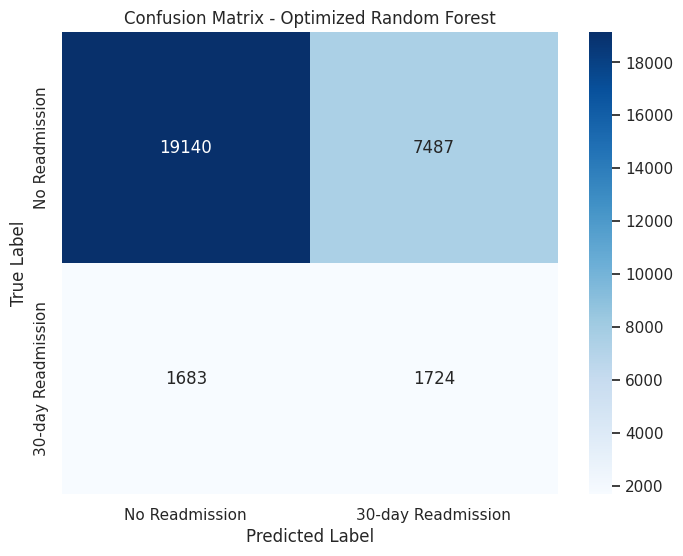

In [19]:

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', '30-day Readmission'], 
            yticklabels=['No Readmission', '30-day Readmission'])
plt.title('Confusion Matrix - Optimized Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")



Confusion Matrix:
True Negatives: 19140
False Positives: 7487
False Negatives: 1683
True Positives: 1724


In [ ]:
# SHAP Analysis for the optimized Random Forest
# We need to extract the classifier from the pipeline and use preprocessed data

# Get the preprocessed test data by transforming through the pipeline steps
X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Get the trained classifier from the pipeline
trained_classifier = best_pipeline.named_steps['classifier']

# Create SHAP explainer for the Random Forest classifier
explainer = shap.TreeExplainer(trained_classifier)

# Calculate SHAP values using the preprocessed test data
# Note: Using a subset for faster computation
sample_size = min(1000, len(X_test_preprocessed))
X_test_sample = X_test_preprocessed[:sample_size]

print(f"Computing SHAP values for {sample_size} test samples...")
shap_values = explainer.shap_values(X_test_sample, check_additivity=False)

# If binary classification, take the positive class SHAP values
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]  # positive class

# Get feature names from the preprocessor
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier handling
X_test_sample_df = pd.DataFrame(X_test_sample, columns=feature_names)

# Summary plot (bar)
shap.summary_plot(shap_values, X_test_sample_df, plot_type='bar', show=False)
plt.title('Mean SHAP Feature Importance - Optimized Random Forest')
plt.tight_layout()
plt.show()

# Detailed summary plot
shap.summary_plot(shap_values, X_test_sample_df, show=False)
plt.title('SHAP Summary Plot - Optimized Random Forest')
plt.tight_layout()
plt.show()


